In [9]:
from dotenv import dotenv_values
import pandas as pd
import pickle
from openai import OpenAI
import tiktoken
import csv
import numpy as np
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [10]:
EMBEDDING_MODEL = "text-embedding-3-small"

In [11]:
config = dotenv_values(".env") 
OPENAI_EMBEDDINGS_KEY = config['API_KEY']

In [12]:
# All Functions Definitions
def combine_fields(row):
    combined_fields = {
        'Product Name': row['Product Name'],
        'Description': row['Description'],
        'Price': row['List Price']
    }
    return combined_fields

# Function to combine specified columns into a CSV-formatted string
def combine_to_csv(row):
    return ','.join(['"{}"'.format(str(value).strip()) if col != 'List Price' else str(value).strip() for col, value in row[['Uniq Id','Product Name', 'Description', 'List Price']].items()])



def generate_embeddings(batch_records,openai_client,model):
    """
        Function to generate embedding of each row and store in "embeddings" column of df
    """
    embeddings = None
    response = openai_client.embeddings.create(
        input=batch_records,
        model=model
    )
    
    embeddings = response.data
    return batch_records,embeddings

def format_embeddings(records,embeddings):
    if len(records) != len(embeddings):
        raise ValueError("Number of records does not match number of embeddings")

    refined_embeddings = []
    merged_data = []
    individual_record= []
    for emb in embeddings:
        refined_embeddings.append(emb.embedding)    

    i = 0
    for r in records:
        row = list(csv.reader([r]))
        split_row = row[0]
        individual_record.append(split_row[0])
        individual_record.append(split_row[1])
        individual_record.append(split_row[2])
        individual_record.append(split_row[3])
        individual_record.append(str(refined_embeddings[i]))
        merged_data.append(individual_record)
        individual_record =[]
        i+=1
    return merged_data


def num_tokens_from_string(string):
    encoding = tiktoken.encoding_for_model("text-embedding-3-small")
    num_tokens = len(encoding.encode(string))
    return num_tokens

def create_batch_records(df,max_tokens=8191):
    """
    This function will iterate the df's COMBINED cloumn.
    each record will be passed to "num_tokens_from_string" function
    to calculate total tokens by each record
    """
    batch = []
    batches = []
    remaining_token = max_tokens
    for index, row in df.iterrows():
        text = row['Combined_CSV'].lower().strip()
        token_count = num_tokens_from_string(text)
        batch.append(text)
        remaining_token = remaining_token - token_count
        if token_count >=remaining_token:
            batches.append(batch)            
            batch = []
            remaining_token = max_tokens
    return batches,len(batches)


def generate_single_embedding(text,openai_client,model):
    """
        Function to generate embedding from a given piece of text
    """
    embeddings = None
    response = openai_client.embeddings.create(
        input=text,
        model=model
    )
    
    embeddings = response.data[0].embedding
    return embeddings


def load_embeddings_from_csv(file_path):
    df = pd.read_csv(file_path)
    embeddings = df['Embedding'].apply(ast.literal_eval)
    return np.array(embeddings.tolist())

# Function to compute similarity between text and embeddings
def compute_similarity(query_embedding, embeddings):
    similarities = cosine_similarity(query_embedding, embeddings)
    return similarities[0]

# Function to get top 5 similar records
def top_5_similar_records(similarities, df_records,input_title, n=5):
    similar_records = []

    
    input_title = input_title.lower()
    top_indices = similarities.argsort()[-(n+1):][::-1]  # Include an extra item to account for input title
    similar_titles = df_records.iloc[top_indices]['Product Name'].str.lower().tolist()
    similar_titles_ids = df_records.iloc[top_indices]['Uniq Id'].tolist()

    
    for idx in top_indices:
        if df_records.iloc[idx]['Product Name'].lower() != input_title:
            title = df_records.iloc[idx]['Product Name']
            ids = df_records.iloc[idx]['Uniq Id']
            similarity = similarities[idx]
            similar_records.append((title, ids, similarity))

#     input_index = similar_titles.index(input_title)
#     similar_titles.pop(input_index)  # Remove the input title from the list of similar titles
#     similar_similarities = similarities[top_indices][1:]  # Exclude the similarity score of the input title
#     similar_records = [(title,ids, similarity) for title,ids, similarity in zip(similar_titles,similar_titles_ids, similar_similarities)]
    return similar_records

def plot_similarity(input_embedding, embeddings):
    # Compute cosine similarity between input embedding and all other embeddings
    similarities = cosine_similarity([input_embedding], embeddings)[0]
    # Plot the cosine similarity scores
    plt.scatter(np.arange(len(embeddings)), similarities, marker='o', linestyle='-')
    plt.xlabel('Embedding Index')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity of Input Query vs. Other Embeddings')
    plt.show()

def plot_embeddings(input_embedding, embeddings):
    # Convert embeddings to numpy array
    embeddings = np.array(embeddings)

    # Concatenate input embedding with all other embeddings
    all_embeddings = np.vstack([input_embedding, embeddings])

    # Use t-SNE to reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    embedded_embeddings = tsne.fit_transform(all_embeddings)

    # Extract coordinates for input embedding and all other embeddings
    input_embedding_coords = embedded_embeddings[0]
    other_embeddings_coords = embedded_embeddings[1:]

    # Plot scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(input_embedding_coords[0], input_embedding_coords[1], color='red', label='Input Query Embeddings')
    plt.scatter(other_embeddings_coords[:, 0], other_embeddings_coords[:, 1], color='blue', label='Existing Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Visualization of Input Query and Existing Embeddings')
    plt.legend()
    plt.grid(True)
    plt.show()
        

## Loading Data CSV File and Filtering Records

In [13]:
csv_file = 'walmart.csv'
text_columns = ['Product Url', 'Product Name', 'Description','List Price', 'Brand']
openai_api_key = 'your_openai_api_key'

df = pd.read_csv(csv_file)
missing_values = df['Category'].isna().any()
if missing_values:
    df['Category'].fillna('', inplace=True)

# Filter the DataFrame to include only records where 'Category' contains 'Foods'
df = df[df['Category'].str.contains('Foods', case=False)]

columns_to_remove = ['Crawl Timestamp', 'Item Number','Gtin','Package Size','Category','Postal Code','Available','Sale Price','Brand']
# Drop the specified columns
df.drop(columns=columns_to_remove, inplace=True)
df['Combined_CSV'] = df.apply(combine_to_csv, axis=1)
small_df = df.tail(500)

## Initiate OpenAI Client

In [14]:
client = OpenAI(api_key=OPENAI_EMBEDDINGS_KEY)

## Displaying records to be embedded

In [15]:
small_df

,Uniq Id,Product Url,Product Name,Description,List Price,Combined_CSV
23,21fee4394b9cc53bb6ddbe4235506a5c,https://www.walmart.com/ip/Health-Warrior-Chia...,"Health Warrior Chia Bar, Acai Berry, 25 G, Pac...",We aim to show you accurate product informati...,23.21,"""21fee4394b9cc53bb6ddbe4235506a5c"",""Health War..."
192,4b2bac516f65b3130fbf8eb8de481df0,https://www.walmart.com/ip/Lily-of-the-Desert-...,"Lily of the Desert, Aloe Herbal Stomach Formul...",We aim to show you accurate product informati...,13.24,"""4b2bac516f65b3130fbf8eb8de481df0"",""Lily of th..."
320,b9c2f0b7b91b7e4527c2f1bf00808302,https://www.walmart.com/ip/La-Victoria-Thick-n...,"La Victoria Thickn Chunky Medium Salsa, 16 oz ...",We aim to show you accurate product informati...,40.66,"""b9c2f0b7b91b7e4527c2f1bf00808302"",""La Victori..."
403,72bfc2afad2695d29d9cb0ffb90e74fa,https://www.walmart.com/ip/Purely-Inspired-Org...,"Purely Inspired Organic Plant Protein Powder, ...",We aim to show you accurate product informati...,19.97,"""72bfc2afad2695d29d9cb0ffb90e74fa"",""Purely Ins..."
637,c8dba9f4ddc7b2f1b479c4ca90ef7281,https://www.walmart.com/ip/One-Degree-Organic-...,"One Degree Organic Foods Granola, Sprouted Org...",We aim to show you accurate product informati...,44.61,"""c8dba9f4ddc7b2f1b479c4ca90ef7281"",""One Degree..."
...,...,...,...,...,...,...
29585,f15347e1b6b516539135e131da4049d9,https://www.walmart.com/ip/Salsa-Og2-Medium/92...,"Salsa,Og2,Medium",We aim to show you accurate product informati...,64.69,"""f15347e1b6b516539135e131da4049d9"",""Salsa,Og2,..."
29657,e4413719be22272a8b35f8dc71339e70,https://www.walmart.com/ip/Doctor-s-Select-Wei...,"Doctors Select Weight Loss 4, Tablets 90 ea (P...",We aim to show you accurate product informati...,30.23,"""e4413719be22272a8b35f8dc71339e70"",""Doctors Se..."
29723,6555fdff291e804bd74bd17de09dd409,https://www.walmart.com/ip/New-England-Natural...,New England Naturals Granola - Organic - Straw...,We aim to show you accurate product informati...,39.12,"""6555fdff291e804bd74bd17de09dd409"",""New Englan..."
29792,08e6e1897b426f757265e9366ff95302,https://www.walmart.com/ip/Suja-Energy-Shot-wi...,"Suja Energy Shot with Coffeeberry and Reishi, ...",We aim to show you accurate product informati...,44.85,"""08e6e1897b426f757265e9366ff95302"",""Suja Energ..."


## Generate Batch Records and Embeddings

The purpose of this step is to get embeddings.
We will first see whethe the embedding csv and data exist, if yes then use it
otherwise create fresh embeddings.

In [16]:
embedding_found = True
formatted_embeddings = []
all_embeddings = []
merged_embeddings = []
x = 0

# load the cache if it exists, and save a copy to disk
try:
    merged_embeddings = pd.read_csv("allembeds.csv")
    print("Embedding File Found")
except FileNotFoundError:
    print("Embedding File Not Found...")
    embedding_found = False

if not embedding_found:
    print("Creating Batches and Embeddings")
    batches,count = create_batch_records(small_df)
    for batch in batches:
        records,embeddings = generate_embeddings(batch,client,EMBEDDING_MODEL)
        formatted_embeddings = format_embeddings(records,embeddings)
        all_embeddings.append(formatted_embeddings)
        x+=1
        if x > 2: # No specific reason, did not want to consume my OpenAI account
            break 


Embedding File Found


## Merging embeddings into a flat array

In [17]:
for emb in all_embeddings:
    for rec in emb:
        merged_embeddings.append(rec)

## Read CSV into Pandas

In [18]:
if not embedding_found:
    df = pd.DataFrame(merged_embeddings, columns =['UniqueID','Title','Desc','Price','Embedding'])
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0.0)
    df.to_csv('allembeds.csv', index=False)


In [19]:
df_combined = pd.read_csv('allembeds.csv')

In [20]:
extracted_embeddings = load_embeddings_from_csv('allembeds.csv')

In [21]:
query = input("Enter product title")
query

Enter product titleHealth Warrior Chia Bar, Acai Berry, 25 G, Pac


'Health Warrior Chia Bar, Acai Berry, 25 G, Pac'

In [22]:
emb_query = generate_single_embedding(query,client,EMBEDDING_MODEL)

## Calculate Cosine Simlarity 

In [23]:
text_embedding_array = np.array(emb_query)
text_embedding_reshaped = text_embedding_array.reshape(1, -1)
similarities = compute_similarity(text_embedding_reshaped, extracted_embeddings)

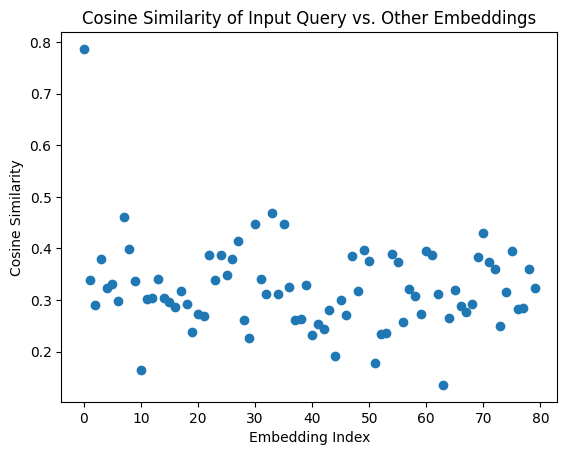

In [24]:
 plot_similarity(emb_query,extracted_embeddings)

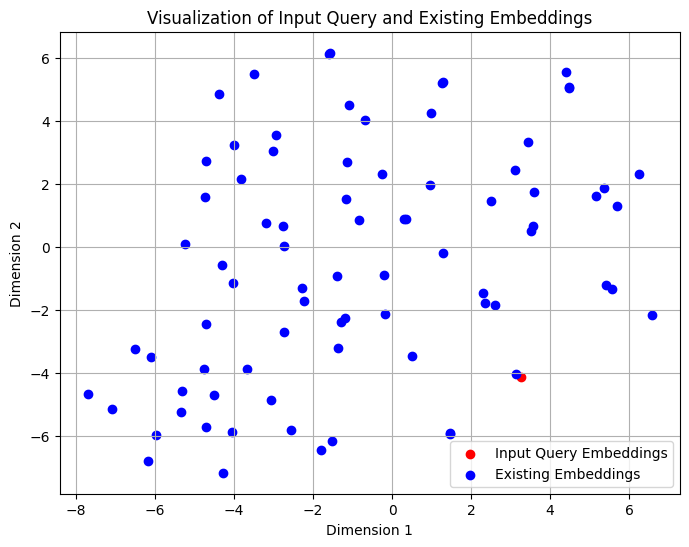

In [25]:
plot_embeddings(emb_query,extracted_embeddings)

## Fetch Top 5 similar records

In [26]:
top5 = top_5_similar_records(similarities,small_df,query)
top5

[('Health Warrior Chia Bar, Acai Berry, 25 G, Pack Of 15',
  '21fee4394b9cc53bb6ddbe4235506a5c',
  0.7865167078326643),
 ('Rise Bar Gluten Free Protein Bars, Chocolatey Coconut, 2.1 Oz, 12 Ct',
  '076ce5498d181a517bdc2863142402c0',
  0.46839342705774173),
 ('Nutrisystem Chocolate Chip Baked Bars Pack, 5 Count - Ready to Eat Meal Replacement Breakfast Bars to Support Healthy Weight Loss',
  '202ab4c56b418153657e2b53b30ef9b3',
  0.4606601758761113),
 ('Pure Organic Pineapple Passion Fruit Bars 0.63 oz 12 ct',
  '269fc6604182f3c027e25280fdffb95b',
  0.4472399354429031),
 ('Go Raw 100% Organic Spirulina Super Chips, 3 oz, (Pack of 12)',
  '08b116626df671a2ad3fb1b1de9d179c',
  0.4471157111214574),
 ('Natures Way Barley Grass Bulk Powder Dietary Supplement, 9 oz',
  '18fc594859d86f440890e87bafa95ef5',
  0.43024825369566544)]